# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression?** We picked the **classification problem** of predicting whether a credit card client will default or not.
- **Report your test score here along with the metric used:** In this problem, we wanted to minimise the instances of false negatives, where negative class is no-default. We also, did not want very high instances of false positives. So, we selected "f1" score as the evaluation metric. The **f1 score on test data using optimized Light GBM model is: 0.54**  
- **Please add a link to your GitHub repository here: https://github.com/UBC-MDS/default_classifier_573_lab4**
- You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group. 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [1]:
import os
import string

import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
alt.themes.enable('default')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
from sklearn import set_config
set_config(display="diagram")

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

<hr>

**Answer_1.1:** We have chosen the **classification problem** in which we try to predict whether a credit card client will default or not. This will be based on multiple features: client demographics, credit and payment history, and other customer information. This data set contains information of credit card clients in Taiwan from April 2005 to September 2005. 

It has 30,000 examples, 24 features and the target variable ("default.payment.next.month"). 

The description of fields in the dataset is given below for reference: (adapted from Kaggle)

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1= 1 month payment delay, 2=2 months payment delay,..., 9=9 months payment delay and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

**Answer_1.2:** Reading the Data (data downloaded in ./data/ folder)

In [3]:
credit_df = pd.read_csv("data/UCI_Credit_Card.csv")
credit_df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
# Check features data types and null values
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

**Answer_1.3: Preliminary data evaluation and processing**

**There are no missing values. Hence, we are not performing any missing value treatment**

In [5]:
# Check for null values
credit_df.isnull().values.any()

False

**Re-naming all the columns to their corresponding months for better interpretability**

In [6]:
credit_df = credit_df.rename(columns= {'default.payment.next.month': 'default',
                                        'PAY_0': 'repay_sep',
                                        'PAY_2': 'repay_aug',
                                        'PAY_3': 'repay_jul',
                                        'PAY_4': 'repay_jun',
                                        'PAY_5': 'repay_may',
                                        'PAY_6': 'repay_apr',
                                        'BILL_AMT1': 'bill_sep',
                                        'BILL_AMT2': 'bill_aug',
                                        'BILL_AMT3': 'bill_jul',
                                        'BILL_AMT4': 'bill_jun',
                                        'BILL_AMT5': 'bill_may',
                                        'BILL_AMT6': 'bill_apr',
                                        'PAY_AMT1': 'pay_sep',
                                        'PAY_AMT2': 'pay_aug',
                                        'PAY_AMT3': 'pay_jul',
                                        'PAY_AMT4': 'pay_jun',
                                        'PAY_AMT5': 'pay_may',
                                        'PAY_AMT6': 'pay_apr'}, inplace = False)

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

**Answer_2.1:** Since we have only 30,000 observations we have decided to do a 80:20 split between the train and test dataset. Additionally we are not using ensemble models or other techniques which require very high processing power, so, we are retaining 80% in training set. This way we have enough samples for validation.

In [7]:
# train-test split
train_df, test_df = train_test_split(credit_df, test_size=0.20, random_state=573)

# creating X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=["default"])
y_train = train_df["default"]

X_test = test_df.drop(columns=["default"])
y_test = test_df["default"]

In [8]:
# Checking X_train shape
X_train.shape

(24000, 24)

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

There are **no missing values**. Hence, we are not performing any missing value treatment. 

**Answer_3.1:** At first, we take a look at the distribution of the **numeric features** in training dataset. 

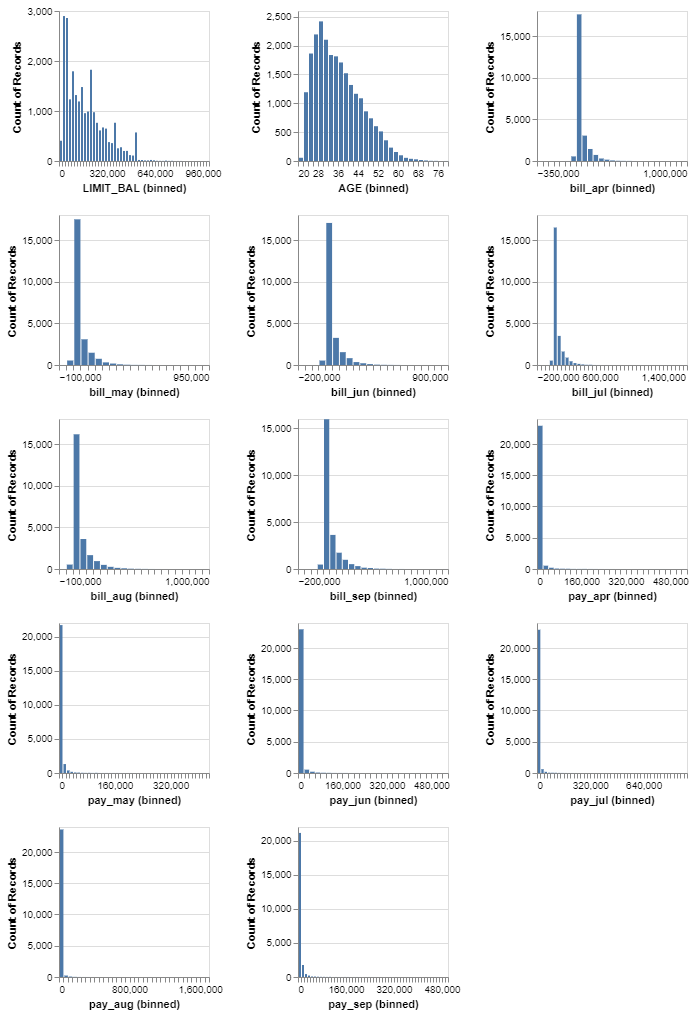

In [9]:
alt.Chart(train_df).mark_bar().encode(
     alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=50),scale=alt.Scale(zero=False)),
     alt.Y('count()', scale=alt.Scale(zero=False))
).properties(
    width=150,
    height=150
).repeat(
    ['LIMIT_BAL', 'AGE', 'bill_apr', 'bill_may', 'bill_jun', 'bill_jul', 'bill_aug', 'bill_sep','pay_apr', 'pay_may', 'pay_jun', 'pay_jul', 
'pay_aug', 'pay_sep'],
    columns=3
).resolve_scale(y='independent')

Here are the summary statistics of numeric features:

In [10]:
train_number_df = train_df[['LIMIT_BAL', 'AGE', 'bill_apr', 
     'bill_may', 'bill_jun', 'bill_jul', 
     'bill_aug', 'bill_sep','pay_apr', 
     'pay_may', 'pay_jun', 'pay_jul', 
     'pay_aug', 'pay_sep']]

train_number_df.describe()

,LIMIT_BAL,AGE,bill_apr,bill_may,bill_jun,bill_jul,bill_aug,bill_sep,pay_apr,pay_may,pay_jun,pay_jul,pay_aug,pay_sep
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000
mean,166637.903333,35.454958,38496.814458,39937.176083,42992.670625,4.670982e+04,48819.145542,50863.103917,5236.224375,4794.267792,4750.700708,5236.218875,5.872582e+03,5631.448375
std,129227.497408,9.197219,58873.260040,60237.533490,63968.874274,6.911220e+04,70700.471576,73078.463787,18157.577834,15129.636201,14991.417631,17261.937805,2.248612e+04,15938.534290
min,10000.000000,21.000000,-339603.000000,-81334.000000,-170000.000000,-1.572640e+05,-69777.000000,-154973.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,50000.000000,28.000000,1229.000000,1702.750000,2301.000000,2.631250e+03,2966.000000,3555.750000,97.750000,259.750000,281.750000,390.000000,8.497500e+02,1000.000000
50%,140000.000000,34.000000,17003.000000,18067.000000,18968.500000,1.995550e+04,20739.500000,22109.000000,1500.000000,1500.000000,1500.000000,1800.000000,2.009000e+03,2100.000000
75%,240000.000000,41.000000,49037.000000,49891.750000,54049.000000,5.973500e+04,63338.000000,66611.750000,4000.000000,4051.000000,4000.000000,4500.000000,5.000000e+03,5002.000000
max,1000000.000000,79.000000,961664.000000,927171.000000,891586.000000,1.664089e+06,983931.000000,964511.000000,528666.000000,426529.000000,528897.000000,896040.000000,1.684259e+06,493358.000000


**Insight : 1** The distribution of numeric features are in scope with reality, where age of the client is peaked toward around 30, the amount of given credit has a mean of 166637 NT dollars. We can see the monthly distribution of statements and of previous payment for the months of May to September. This also proofs that numeric features don't have any NaN values. 

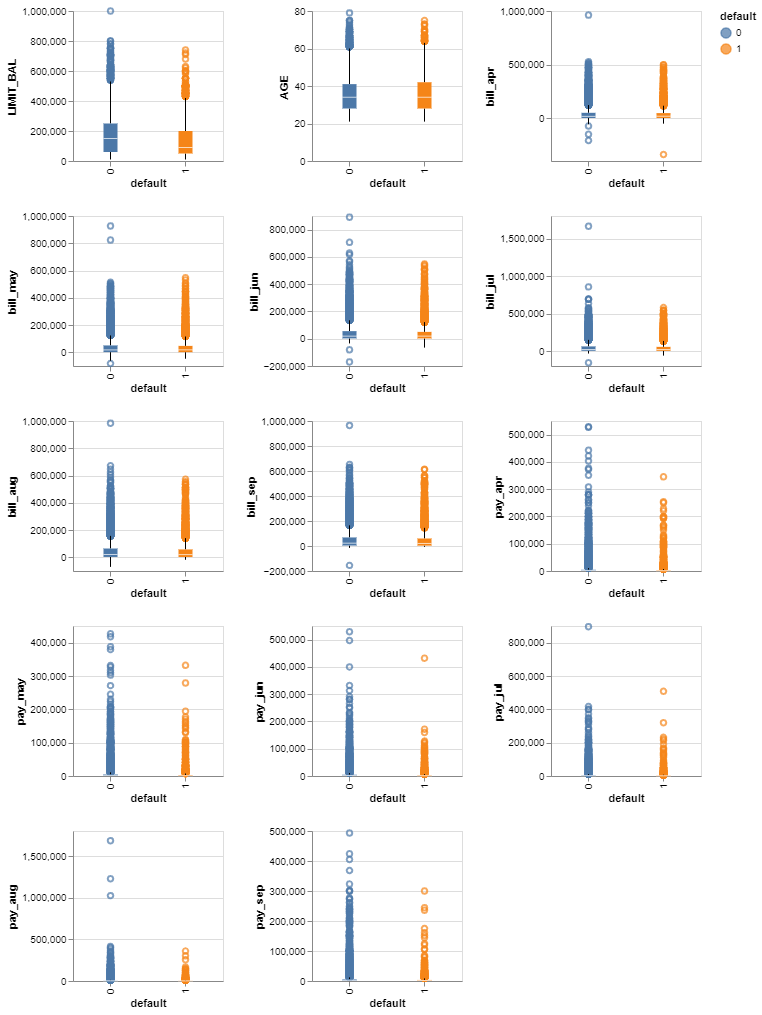

In [11]:
alt.Chart(train_df).mark_boxplot().encode(
    alt.X('default', type='nominal'),
    alt.Y(alt.repeat(), type='quantitative'),
    alt.Color('default', type='nominal')
).properties(
    width=150,
    height=150
).repeat(
    ['LIMIT_BAL', 'AGE', 'bill_apr', 
     'bill_may', 'bill_jun', 'bill_jul', 
     'bill_aug', 'bill_sep','pay_apr', 
     'pay_may', 'pay_jun', 'pay_jul', 
     'pay_aug', 'pay_sep'],
    columns=3
)

**Insight : 2** Our target feature is **"default"**, which denotes whether the client is a defaulter when it come to credit repay. Here we can see the distribution of the numeric features across default status. We can see an association with higher credit limit with being a defaulter. 

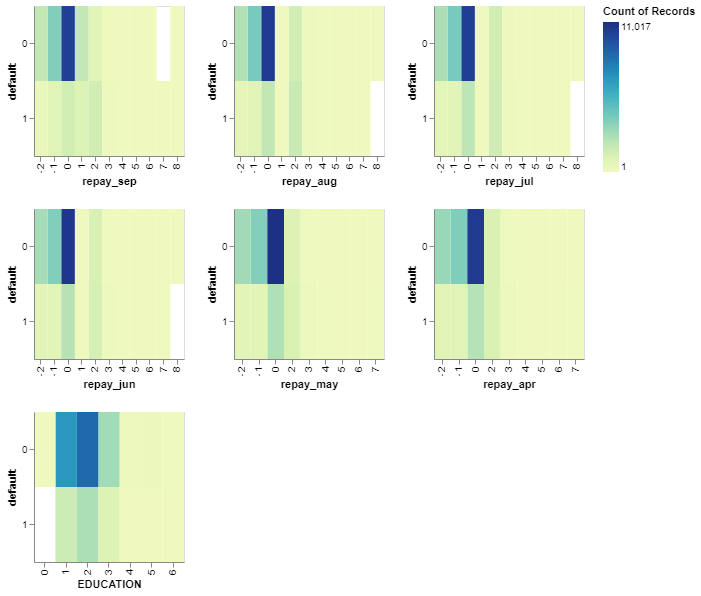

In [12]:
alt.Chart(train_df).mark_rect().encode(
    alt.X(alt.repeat(), type='ordinal'),
    y='default:N',
    color='count()',
    size='count()').properties(
    width=150,
    height=150
).properties(
    width=150,
    height=150
).repeat(
    ['repay_sep', 'repay_aug', 'repay_jul', 
     'repay_jun', 'repay_may', 'repay_apr',
    'EDUCATION'],
    columns=3
)

As for ordinal features, we can see the distribution of academic qualifications namely 
- graduate school (1)
- university (2)
- high school (3)
- others (4)
- unknown (5,6)
across default status.

**Insight :3** Beside, we can see the history of repaying credit from April to September (-1=pay duly, 1= 1 month payment delay, 2=2 months payment delay,..., 9=9 months payment delay and above). We can see that graduates and University students are more prone to default. 

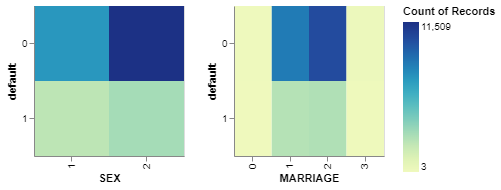

In [13]:
alt.Chart(train_df).mark_rect().encode(
    alt.X(alt.repeat(), type='nominal'),
    y='default:N',
    color='count()',
    size='count()').properties(
    width=150,
    height=150
).properties(
    width=150,
    height=150
).repeat(
    ['SEX', 'MARRIAGE']
)

**Insight:4** Here, we can see binary and categorical features, Marital status (1=married, 2=single, 3=others) and Sex (1=male, 2=female), and their distribution across default status. Here a slight increased habit of repaying credit can be seen among females. 

In [14]:
train_cat_df = train_df[['repay_sep', 'repay_aug', 'repay_jul', 
     'repay_jun', 'repay_may', 'repay_apr',
    'EDUCATION','SEX', 'MARRIAGE']]

train_cat_df.agg(['count', 'unique', 'min', 'max'])

,repay_sep,repay_aug,repay_jul,repay_jun,repay_may,repay_apr,EDUCATION,SEX,MARRIAGE
count,24000,24000,24000,24000,24000,24000,24000,24000,24000
unique,"[0, -1, 1, -2, 2, 3, 4, 5, 8, 6, 7]","[0, -1, 2, -2, 5, 3, 4, 7, 1, 6, 8]","[0, -1, 2, -2, 4, 3, 6, 7, 5, 1, 8]","[0, 2, -1, -2, 3, 8, 4, 5, 7, 6, 1]","[-1, 0, 2, -2, 7, 4, 3, 5, 6]","[-1, 0, 2, -2, 6, 3, 4, 7, 5]","[3, 1, 2, 5, 6, 4, 0]","[1, 2]","[1, 2, 3, 0]"
min,-2,-2,-2,-2,-2,-2,0,1,0
max,8,8,8,8,7,7,6,2,3


Summary statistics of the features are displayed here.

In [15]:
credit_df["default"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default, dtype: float64

**Problem of class imbalance** : As we can see there is a class imbalance problem, since the positive class (default) represents only 22% of the total examples. However, this is expected, as the number of clients defaulting would always be significantly lesser than those not defaulting. 

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

**Answer_4.1:** We have extracted the following features:
1) default_sep, default_aug, default_jul, default_jun, default_may, default_apr [**tendency to default**]: categorize the payment status in 3 possible levels depending on how close to the due date the client paid the balance in that given month (no default, soft default or hard default),
2) defaulter_3m, defaulter_6m [ **payment made/ default status**] : indicate whether the client has or not defaulted in the last 3/6 months,
3) util_sep, util_aug, util_jul, util_jun, util_may, util_apr [**spent vs credit limit**] indicate the percentage of credit utilization in that given month

In [16]:
# Define function for creating default_<month> features (description of these features is given above)
def default_category(x):
    """
    Categorize the payment status in 3 possible levels
    depending on how close to the due date the client paid the balance in that given month

    Parameters
    ----------
    x : integer
        Repayment status for a given month 
        (-1=pay duly, 1 = 1 month of delay,..., 9=9 months of delay and above)

    Returns
    -------
    integer:    0 if the balance for that particular month was paid timely, 
                1 if it was paid within 3 months past due, 
                2 if was paid with 4 or more months of delay
    """
    if x <= 0:
        return 0
    elif x > 0 and x < 4:
        return 1
    else:
        return 2

# Creating default_<month> features using default_category()
X_train['default_apr'] = X_train.apply(lambda X_train: default_category(X_train['repay_apr']), axis=1)
X_train['default_may'] = X_train.apply(lambda X_train: default_category(X_train['repay_may']), axis=1)
X_train['default_jun'] = X_train.apply(lambda X_train: default_category(X_train['repay_jun']), axis=1)
X_train['default_jul'] = X_train.apply(lambda X_train: default_category(X_train['repay_jul']), axis=1)
X_train['default_aug'] = X_train.apply(lambda X_train: default_category(X_train['repay_aug']), axis=1)
X_train['default_sep'] = X_train.apply(lambda X_train: default_category(X_train['repay_sep']), axis=1)

In [17]:
# Creating features to check if a client has defaulted in 6/ 3 months
X_train['defaulter_6m'] = X_train['default_apr'] + X_train['default_may'] + X_train['default_jun']+ X_train['default_jul'] + X_train['default_aug']+ X_train['default_sep']
X_train['defaulter_3m'] = X_train['default_jul'] + X_train['default_aug'] + X_train['default_sep']

In [18]:
X_train['defaulter_6m'] = X_train.apply(lambda X_train: 1 if X_train['defaulter_6m']>0 else 0, axis=1)
X_train['defaulter_3m'] = X_train.apply(lambda X_train: 1 if X_train['defaulter_3m']>0 else 0, axis=1)

In [19]:
# Creating feature to capture Credit card limit utilization
X_train['util_sep'] = X_train['bill_sep']/X_train['LIMIT_BAL']
X_train['util_aug'] = X_train['bill_aug']/X_train['LIMIT_BAL']
X_train['util_jul'] = X_train['bill_jul']/X_train['LIMIT_BAL']
X_train['util_jun'] = X_train['bill_jun']/X_train['LIMIT_BAL']
X_train['util_may'] = X_train['bill_may']/X_train['LIMIT_BAL']
X_train['util_apr'] = X_train['bill_apr']/X_train['LIMIT_BAL']

In [20]:
# Creating all the new feature for test set
X_test['default_apr'] = X_test.apply(lambda X_test: default_category(X_test['repay_apr']), axis=1)
X_test['default_may'] = X_test.apply(lambda X_test: default_category(X_test['repay_may']), axis=1)
X_test['default_jun'] = X_test.apply(lambda X_test: default_category(X_test['repay_jun']), axis=1)
X_test['default_jul'] = X_test.apply(lambda X_test: default_category(X_test['repay_jul']), axis=1)
X_test['default_aug'] = X_test.apply(lambda X_test: default_category(X_test['repay_aug']), axis=1)
X_test['default_sep'] = X_test.apply(lambda X_test: default_category(X_test['repay_sep']), axis=1)
X_test['defaulter_6m'] = X_test['default_apr'] + X_test['default_may'] + X_test['default_jun']+ X_test['default_jul'] + X_test['default_aug']+ X_test['default_sep']
X_test['defaulter_3m'] = X_test['default_jul'] + X_test['default_aug']+ X_test['default_sep']
X_test['defaulter_6m'] = X_test.apply(lambda X_test: 1 if X_test['defaulter_6m']>0 else 0, axis=1)
X_test['defaulter_3m'] = X_test.apply(lambda X_test: 1 if X_test['defaulter_3m']>0 else 0, axis=1)
X_test['util_sep'] = X_test['bill_sep']/X_test['LIMIT_BAL']
X_test['util_aug'] = X_test['bill_aug']/X_test['LIMIT_BAL']
X_test['util_jul'] = X_test['bill_jul']/X_test['LIMIT_BAL']
X_test['util_jun'] = X_test['bill_jun']/X_test['LIMIT_BAL']
X_test['util_may'] = X_test['bill_may']/X_test['LIMIT_BAL']
X_test['util_apr'] = X_test['bill_apr']/X_test['LIMIT_BAL']

In [21]:
X_test.shape

(6000, 38)

In [22]:
X_train.shape

(24000, 38)

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

**Answer_5.1**

In [23]:
# The following features are numeric. We are applying StandardScaling() on numeric features. 
# Since, there are no missing values, we are not applying Imputation.
numeric_features = ['LIMIT_BAL', 'AGE',
                    'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
                    'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
                    'util_sep', 'util_aug', 'util_jul', 'util_jun', 'util_may', 'util_apr']

# The following features are binary. We are using binary transformation, using OneHotEncoder(binary=True)
# The client can either be a defaulter or not. Sex has been described in this dataset as Male/Female only.
binary_features = ['defaulter_6m', 'defaulter_3m', 'SEX']

# The following features are ordinal as we can see there is a ranking in them. We are using Ordinal encoding for there.

ordinal_features_repay = ['repay_sep', 'repay_aug', 'repay_jul', 'repay_jun', 'repay_may', 'repay_apr']
ordinal_features_def = ['default_apr', 'default_may', 'default_jun','default_jul', 'default_aug', 'default_sep']
ordinal_features_edu = ['EDUCATION']

# The following features are categorical. We are using OneHotENcoding for these.
categorical_features = ['MARRIAGE']

# The following features are being dropped.
# The ID column does not bring additional value in this particular scenario.
drop_features = ['ID']

In [24]:
ordering = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
ordering_ordinal_repay = [ordering] * len(ordinal_features_repay)
ordering_ordinal_repay

[[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [25]:
ordering_def = [0, 1, 2]
ordering_ordinal_def = [ordering_def] * len(ordinal_features_def)
ordering_ordinal_def

[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]

In [26]:
ordering_ordinal_edu = [[0, 1, 2, 3, 4, 5, 6]]

**Answer_5.2**

In [27]:
# Creating column transformer (pre-processor)

numeric_transformer = make_pipeline(StandardScaler())
ordinal_transformer_rep = make_pipeline(OrdinalEncoder(categories=ordering_ordinal_repay),)
ordinal_transformer_def = make_pipeline(OrdinalEncoder(categories=ordering_ordinal_def),)
ordinal_transformer_edu = make_pipeline(OrdinalEncoder(categories=ordering_ordinal_edu),)
binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary", dtype=int, sparse=False),)
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False),)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_rep, ordinal_features_repay),
    (ordinal_transformer_def, ordinal_features_def),
    (ordinal_transformer_edu, ordinal_features_edu),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

**Transformed data**

In [28]:
df = pd.DataFrame(preprocessor.fit_transform(X_train))
df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.134750,1.472763,-0.506071,-0.518383,-0.484336,-0.503422,-0.656534,-0.640658,-0.276910,-0.204023,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.134750,0.494186,-0.464977,-0.437462,-0.399819,-0.362569,-0.330983,-0.653907,-0.272330,-0.195439,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.057366,1.472763,-0.351946,-0.325155,-0.254487,-0.230049,-0.324508,-0.304760,-0.259217,-0.061043,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.515674,-0.593122,0.565909,0.413681,0.441757,0.702330,0.588496,0.525091,-0.137810,-0.056240,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.877247,0.167994,-0.685991,-0.688145,-0.664496,-0.656031,-0.648250,-0.642050,-0.342790,-0.226215,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.902597,-1.354237,-0.486160,-0.426288,-0.394249,-0.407999,-0.369714,-0.327589,-0.127458,-0.198908,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
23996,-0.128752,0.929109,-0.549463,-0.620053,-0.664293,0.215849,0.243223,-0.654026,-0.344735,0.441500,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
23997,1.109401,-0.810584,-0.693476,-0.687890,-0.624502,-0.661893,-0.424730,-0.383286,-0.353330,-0.102536,...,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
23998,-1.134750,1.472763,-0.431054,-0.413162,-0.681527,-0.368619,-0.460091,-0.618066,-0.278039,-0.254055,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

**Answer_6.1**

In [29]:
results_base = {}

In [30]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [31]:
# Use sklearn Dummyclassifier as baseline
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
pipe_dm = make_pipeline(preprocessor, DummyClassifier(random_state=123))
results_base['Dummy'] = mean_std_cross_val_scores(pipe_dm, X_train, y_train, return_train_score = True, scoring = scoring)
pd.DataFrame(results_base)

,Dummy
fit_time,0.088 (+/- 0.010)
score_time,0.081 (+/- 0.013)
test_accuracy,0.780 (+/- 0.000)
train_accuracy,0.780 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
train_precision,0.000 (+/- 0.000)


This is expected as most of the cases are of no-default. The baseline classifier is tagging them as no default. Hence we are getting zero recall and f1-score. 

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

We are using **Logistic Regression** as a liner model.

**Answer_7.1:**

In [32]:
# Fitting LogisticRegression (linear model)
results = {}
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, multi_class='ovr') )
results_base['Logistic Regression'] = mean_std_cross_val_scores(pipe_lr, X_train, y_train, return_train_score = True, scoring = scoring)
pd.DataFrame(results_base)

,Dummy,Logistic Regression
fit_time,0.088 (+/- 0.010),1.102 (+/- 0.172)
score_time,0.081 (+/- 0.013),0.081 (+/- 0.012)
test_accuracy,0.780 (+/- 0.000),0.808 (+/- 0.005)
train_accuracy,0.780 (+/- 0.000),0.810 (+/- 0.001)
test_f1,0.000 (+/- 0.000),0.401 (+/- 0.017)
train_f1,0.000 (+/- 0.000),0.407 (+/- 0.007)
test_recall,0.000 (+/- 0.000),0.291 (+/- 0.013)
train_recall,0.000 (+/- 0.000),0.297 (+/- 0.007)
test_precision,0.000 (+/- 0.000),0.643 (+/- 0.023)
train_precision,0.000 (+/- 0.000),0.647 (+/- 0.007)


**Answer_7.2:**

In [33]:
#  Hyperparameter Optimization (C and class_weight)
param = {
    "logisticregression__C": [0.01, 0.1, 1, 10, 100, 1000],
    "logisticregression__class_weight": [None, "balanced"]
}

In [34]:
random_search = RandomizedSearchCV(pipe_lr, param,
                                   n_iter=10,
                                   verbose=0,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['MARRIAGE'])])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=2000,
                                                                 multi_class='ovr'))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.01, 0.1, 1,
                                                                  10, 100,
                                                                  1000],
                                        'logisticregression__class_weight': [None,
                                                                             'balanced']},
                   random_state=123, return_train_score=True, scoring='f1')

**Answer_7.3:**

In [35]:
# Results for Hyperparameter optimization (linear model)
pd.DataFrame(random_search.cv_results_)[
    [
        "rank_test_score",
        "mean_test_score",
        "param_logisticregression__C",
        "param_logisticregression__class_weight",
        "mean_fit_time",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,7,7,10
mean_test_score,0.521808,0.521801,0.52164,0.521434,0.521198,0.400991,0.400579,0.400579,0.400579,0.391984
param_logisticregression__C,0.1,1,10,100,0.01,1,100,1000,10,0.01
param_logisticregression__class_weight,balanced,balanced,balanced,balanced,balanced,None,None,None,None,None
mean_fit_time,1.152125,1.009591,1.340245,1.133521,0.630243,1.981825,1.090044,1.565672,1.243051,0.553196


**Answer_7.4:** Summary of hyperparameter optimization: We have used **'f1'** score for evaluating the model performances. In the above optimization, the best test score is **0.522** and this is achieved for C value of 0.1 and class_weight 'balanced'. We also notice in the above table that for class_weight, the top few scores are obtained using 'balanced' observations. This indicates that class imbalance would have a negative impact on model performance. For C, we observe large deviation in values for the top performing models.

In [36]:
# Best hyperparameters: optimized for f1-score
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

Best hyperparameter values:  {'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.1}
Best score: 0.522


In [37]:
# Model for using the best hyperparameter
pipe_lr_best = make_pipeline(preprocessor,
                             LogisticRegression(max_iter=2000, 
                                                C = random_search.best_params_.get("logisticregression__C"),
                                                class_weight = random_search.best_params_.get("logisticregression__class_weight"),))

In [38]:
# Evaluation of optimized Logistic Regression model
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
results_base['Logistic Regression_best'] = mean_std_cross_val_scores(pipe_lr_best, X_train, y_train, return_train_score = True, scoring = scoring)
results_base = pd.DataFrame(results_base)
results_base

,Dummy,Logistic Regression,Logistic Regression_best
fit_time,0.088 (+/- 0.010),1.102 (+/- 0.172),0.665 (+/- 0.112)
score_time,0.081 (+/- 0.013),0.081 (+/- 0.012),0.088 (+/- 0.015)
test_accuracy,0.780 (+/- 0.000),0.808 (+/- 0.005),0.751 (+/- 0.006)
train_accuracy,0.780 (+/- 0.000),0.810 (+/- 0.001),0.752 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.401 (+/- 0.017),0.522 (+/- 0.014)
train_f1,0.000 (+/- 0.000),0.407 (+/- 0.007),0.523 (+/- 0.004)
test_recall,0.000 (+/- 0.000),0.291 (+/- 0.013),0.618 (+/- 0.020)
train_recall,0.000 (+/- 0.000),0.297 (+/- 0.007),0.619 (+/- 0.004)
test_precision,0.000 (+/- 0.000),0.643 (+/- 0.023),0.451 (+/- 0.011)
train_precision,0.000 (+/- 0.000),0.647 (+/- 0.007),0.453 (+/- 0.004)


It is observed that both train score and test score improve after hyper-parameter optimization for Logistic Regression model. It is also observed that this model does not have Overfitting as the gap between training scrore and test score is negligible.

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [39]:
# Dropping the tuned model as we want to have a like-to-like comparison for all models
results = results_base.drop('Logistic Regression_best', axis=1)

**Answer_8.1**

In [40]:
# Taking class_weight as 'balanced' as their is class imbalance issue
pipe_kNN = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocessor, SVC(random_state=123, class_weight = "balanced"))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123, class_weight = "balanced"))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, class_weight = "balanced"))
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))

classifiers = {
    "kNN": pipe_kNN,
    "SVC": pipe_svc,
    "Random Forest": pipe_rf,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [41]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring)

In [42]:
pd.DataFrame(results)

,Dummy,Logistic Regression,kNN,SVC,Random Forest,LightGBM,CatBoost
fit_time,0.088 (+/- 0.010),1.102 (+/- 0.172),0.092 (+/- 0.028),45.393 (+/- 7.270),5.926 (+/- 0.297),0.596 (+/- 0.033),11.780 (+/- 0.956)
score_time,0.081 (+/- 0.013),0.081 (+/- 0.012),4.674 (+/- 0.621),20.755 (+/- 5.043),0.290 (+/- 0.039),0.123 (+/- 0.007),0.205 (+/- 0.028)
test_accuracy,0.780 (+/- 0.000),0.808 (+/- 0.005),0.793 (+/- 0.005),0.750 (+/- 0.009),0.813 (+/- 0.005),0.756 (+/- 0.005),0.820 (+/- 0.005)
train_accuracy,0.780 (+/- 0.000),0.810 (+/- 0.001),0.844 (+/- 0.002),0.756 (+/- 0.006),0.999 (+/- 0.000),0.819 (+/- 0.002),0.862 (+/- 0.001)
test_f1,0.000 (+/- 0.000),0.401 (+/- 0.017),0.431 (+/- 0.013),0.522 (+/- 0.012),0.442 (+/- 0.015),0.529 (+/- 0.011),0.470 (+/- 0.017)
train_f1,0.000 (+/- 0.000),0.407 (+/- 0.007),0.571 (+/- 0.005),0.534 (+/- 0.004),0.999 (+/- 0.000),0.658 (+/- 0.002),0.604 (+/- 0.003)
test_recall,0.000 (+/- 0.000),0.291 (+/- 0.013),0.357 (+/- 0.013),0.620 (+/- 0.013),0.337 (+/- 0.015),0.624 (+/- 0.015),0.363 (+/- 0.016)
train_recall,0.000 (+/- 0.000),0.297 (+/- 0.007),0.472 (+/- 0.006),0.634 (+/- 0.009),1.000 (+/- 0.000),0.794 (+/- 0.007),0.477 (+/- 0.003)
test_precision,0.000 (+/- 0.000),0.643 (+/- 0.023),0.544 (+/- 0.017),0.450 (+/- 0.014),0.646 (+/- 0.024),0.460 (+/- 0.009),0.667 (+/- 0.019)
train_precision,0.000 (+/- 0.000),0.647 (+/- 0.007),0.721 (+/- 0.005),0.461 (+/- 0.008),0.998 (+/- 0.001),0.562 (+/- 0.004),0.824 (+/- 0.004)


**Answer_8.2:** The above results highlight the following about the evaluated models:
- **Best and worst performing models:** For comparing performance, we will consider test scores as the training scores will be considered while evaluating overfit/underfit. The f1 and recall test scores for LGBM and SVC models are the best and comparable to each other. While Random Forest and Cat Boost have high precision score, roc_auc values are comparable for all models. 
- **Overfitting/underfitting:** it is observed that Random Forest has highest degree of Overfitting as there is a significant gap between train scores and test scores. 
- **Fit time:** It is observed that the fit time for SVC model is significantly higher than the other models. The fit time for KNN model is the least. The fit time for LGBM and Logistic Regression is also on the lower side compared to the other models.
- **Score time:** It is observed that Score time for SVC model is significantly higher than the other models. The score time for all other models is comparable to each other.

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [43]:
# using RFECV for feature selection
score = {}
rfecv = RFECV(RidgeClassifier())
pipe_rfecv = make_pipeline(preprocessor, rfecv, LogisticRegression(random_state=123))
score["Logistic Regression RFECV"] = mean_std_cross_val_scores(pipe_rfecv, X_train, y_train, return_train_score=True, scoring ="f1")

In [44]:
# using L1-regularization
pipe_lgr_l1 = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", penalty="l1"))

score["Logistic Regression L1"] = mean_std_cross_val_scores(pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring = "f1")

In [45]:
pd.DataFrame(score)

,Logistic Regression RFECV,Logistic Regression L1
fit_time,3.719 (+/- 0.189),2.454 (+/- 0.577)
score_time,0.025 (+/- 0.009),0.026 (+/- 0.016)
test_score,0.392 (+/- 0.019),0.401 (+/- 0.017)
train_score,0.399 (+/- 0.008),0.407 (+/- 0.007)


**No**, we do not see improvement in model performance after doing feature selection as the f1 test score before and after feature selection is 0.401. So, we abandon feature selection for the next sections.

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [46]:
# Hyperparameter Optimization for KNN
param_grid = {
    "kneighborsclassifier__n_neighbors": list(range(1,15))
}

random_search_knn = RandomizedSearchCV(pipe_kNN, param_grid,
                                   n_iter=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                                                                'SEX']),
                                                                              ('pipeline-6',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['MARRIAGE'])])),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              11,
                                                                              12,
                                                                           

In [47]:
print("Best hyperparameter values for KNN: ", random_search_knn.best_params_)
print("Best score for KNN: %0.3f" % (random_search_knn.best_score_))

Best hyperparameter values for KNN:  {'kneighborsclassifier__n_neighbors': 11}
Best score for KNN: 0.435


**Comment:** f1-test score for KNN model before hyperparameter optimization was 0.431. The best f1 score for KNN model after hyperparameter optimization is **0.435**. So, we see only marginal improvement in model performance and the optimized hyperparameter is n_neighbors = 11.

In [48]:
# Hyperparameter Optimization for SVC model
param_grid = {
   "svc__class_weight": [None,"balanced"],
   "svc__gamma": np.logspace(-3, 0, 4),
   "svc__C": np.logspace(-2, 3, 6)
}

random_search_svc = RandomizedSearchCV(pipe_svc, param_grid,
                                   n_iter=5,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search_svc.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['MARRIAGE'])])),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  random_state=123))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__gamma': array([0.001, 0.01 , 0.1  , 1.   ])},
                   random_state=123, return_train_score=True, scoring='f1')

In [49]:
print("Best hyperparameter values for SVC: ", random_search_svc.best_params_)
print("Best score for SVC: %0.3f" % (random_search_svc.best_score_))

Best hyperparameter values for SVC:  {'svc__gamma': 0.01, 'svc__class_weight': 'balanced', 'svc__C': 0.1}
Best score for SVC: 0.522


**Comment:** f1-test score for SVC model before hyperparameter optimization was 0.522. The best f1 score for SVC model after hyperparameter optimization is **0.523**. So, we see only marginal improvement in model performance and the optimized hyperparameter is {gamma: 0.01, class_weight: 'balanced', C': 0.1}.

In [50]:
# Hyperparameter Optimization for Random Forest model
param_grid = {
    "randomforestclassifier__class_weight": [None,"balanced"],
   "randomforestclassifier__n_estimators": [10, 50, 100],
   "randomforestclassifier__max_depth": list(range(1, 10))
}

random_search_rf = RandomizedSearchCV(pipe_rf, param_grid,
                                   n_iter=5,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=123))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__class_weight': [None,
                                                                                 'balanced'],
                                        'randomforestclassifier__max_depth': [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 50,
                                                                                 100]},
                   random_state=123, return_train_score=True, scoring='f1')

In [51]:
print("Best hyperparameter values for Random Forest: ", random_search_rf.best_params_)
print("Best score for Random Forest: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values for Random Forest:  {'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__class_weight': 'balanced'}
Best score for Random Forest: 0.527


**Comment:** f1-test score for Random Forest model before hyperparameter optimization was 0.442. The best f1 score for Random Forest model after hyperparameter optimization is **0.527**. So, in this case, we see a good improvement in model performance and the optimized hyperparameter is {n_estimators: 10, max_depth: 5, class_weight: 'balanced'}. However, performance of the tuned model is similar to LGBM model before optimization.

In [52]:
# Hyperparameter Optimization for LightGBM model
param_grid = {
     "lgbmclassifier__class_weight": [None,"balanced"],
    "lgbmclassifier__num_leaves": [10, 30, 50],
     "lgbmclassifier__learning_rate": 10.0 ** np.arange(-3, 4),
    "lgbmclassifier__n_estimators":[100,200,300,500]
}

random_search_lgb = RandomizedSearchCV(pipe_lgbm, param_grid,
                                   n_iter=5,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search_lgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=123))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'lgbmclassifier__class_weight': [None,
                                                                         'balanced'],
                                        'lgbmclassifier__learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'lgbmclassifier__n_estimators': [100,
                                                                         200,
                                                                         300,
                                                                         500],
                                        'lgbmclassifier__num_leaves': [10, 30,
                                                                       50]},
                   random_state=123, return_train_score=True, scoring='f1')

In [53]:
print("Best hyperparameter values for LightGBM: ", random_search_lgb.best_params_)
print("Best score for LightGBM: %0.3f" % (random_search_lgb.best_score_))

Best hyperparameter values for LightGBM:  {'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__n_estimators': 100, 'lgbmclassifier__learning_rate': 0.001, 'lgbmclassifier__class_weight': 'balanced'}
Best score for LightGBM: 0.518


**Comment:** f1-test score for Light GBM model before hyperparameter optimization was 0.529. The best f1 score for Light GBM model after hyperparameter optimization is **0.518**. So, we see do not see much improvement in model performance and the optimized hyperparameter is {num_leaves: 50, n_estimators: 100, learning_rate: 0.001, class_weight: 'balanced'}.

In [54]:
# Hyperparameter Optimization for CatBoost model
param_grid = {
   "catboostclassifier__learning_rate": np.random.uniform(0,1,10)
}

random_search_cat = RandomizedSearchCV(pipe_catboost, param_grid,
                                   n_iter=5,
                                   n_jobs=-1,
                                   scoring="f1",
                                   return_train_score=True,
                                   random_state=123)
random_search_cat.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['ID']),
                                                                              ('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'bill_sep',
                                                                                'bill_aug',
                                                                                'bill_jul',
                                                                                'bill_jun',
                                                                                'bill_may',
                                                                                'bill_apr',
                                                                                'pay_sep',
                                                                                'pay_aug',
                                                                                'pay_jul',
                                                                                'pay_jun',
                                                                                'pay_may',
                                                                                'pay_apr',
                                                                                'util_sep',
                                                                                'util...
                                                                               ['MARRIAGE'])])),
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x000002ACFD22E3A0>)]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'catboostclassifier__learning_rate': array([0.59556796, 0.25593105, 0.514896  , 0.40773223, 0.75716178,
       0.31861042, 0.82839378, 0.22594168, 0.32940636, 0.36363317])},
                   random_state=123, return_train_score=True, scoring='f1')

In [55]:
print("Best hyperparameter values for CatBoost: ", random_search_cat.best_params_)
print("Best score for CatBoost: %0.3f" % (random_search_cat.best_score_))

Best hyperparameter values for CatBoost:  {'catboostclassifier__learning_rate': 0.22594167732467807}
Best score for CatBoost: 0.454


**Comment:** f1-test score for Cat Boost model before hyperparameter optimization was 0.47. The best f1 score for Cat boost model after hyperparameter optimization is **0.47**. So, we do not see improvement in model performance and the optimized hyperparameter is {learning_rate: 0.19330417992610038}. 

**Answer_10.2:**
We have captured the comments pertaining to hyperparameter optimization of specific models above. On considering all the tuned models above, we observe that there is only marginal improvement in model performance after hyperparameter tuning. Only in case of Random Forest, we see a good improvement in performance.

Looking across all the parameters, across different models. **Light GBM** {num_leaves: 50, n_estimators: 100, learning_rate: 0.001, class_weight: 'balanced'} is the best choice, as it is not overfitting, giving best f1-score, and lower fit and score time

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

**Answer_11.1:**

In [56]:
# Using SHAP on the best performing model (LGBM) with hyper-parameters (########)
pipe_lgbm_tuned = make_pipeline(preprocessor,
                               LGBMClassifier(random_state=123, 
                                              class_weight = "balanced", 
                                              n_estimators = random_search_lgb.best_params_.get("lgbmclassifier__n_estimators"),
                                              learning_rate = random_search_lgb.best_params_.get("lgbmclassifier__learning_rate"),
                                             num_leaves = random_search_lgb.best_params_.get("lgbmclassifier__num_leaves")))

In [57]:
# Extract features names
ohe_feature_names = (
    pipe_lgbm_tuned.named_steps["columntransformer"]
    .named_transformers_["pipeline-6"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names = (
    numeric_features + 
    ordinal_features_repay + 
    ordinal_features_def +
    ordinal_features_edu +
    binary_features + 
    ohe_feature_names
)
len(feature_names)

40

In [58]:
import shap

# create enconded data (train and test)
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

pipe_lgbm_tuned.fit(X_train, y_train);

In [59]:
lgbm_explainer = shap.TreeExplainer(pipe_lgbm_tuned.named_steps["lgbmclassifier"])

# Extract only shapely values 
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

**Global feature importances for class 1 (default)**

In [60]:
pipe_lgbm_tuned.named_steps["lgbmclassifier"].classes_

array([0, 1], dtype=int64)

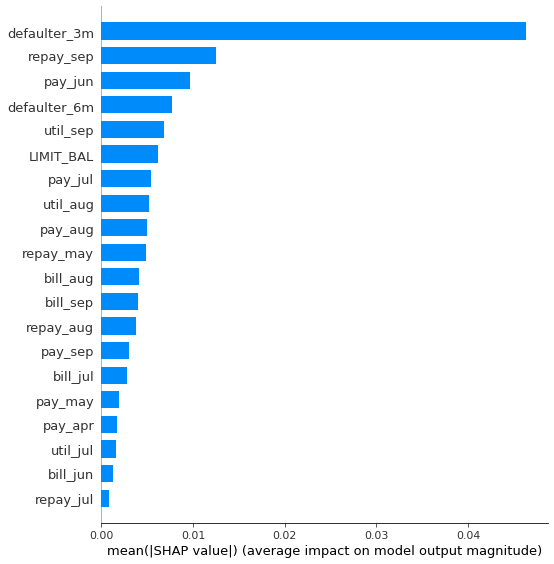

In [61]:
shap.initjs()
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

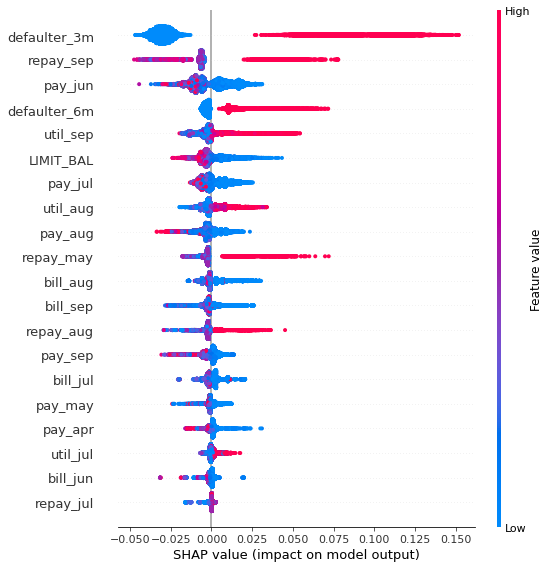

In [62]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

**Answer_11.2:** The summary of feature importance analysis is given below:
* The first plot shows global feature importances for predicting class 1 (default), whereas the second one also shows the direction of how the feature will drive the prediction.
* The features are ranked in descending order of feature importances.
* Colour shows the value of feature (red for a higher value and blue for a lower value)
* Presence of previous default on the past 3 months seems to have bigger SHAP values and absence seems to have smaller SHAP values for class 1 (default).
* Many features related to the latest months are also showing up as most important features, such as bill, amount of previous payment and repayment status for the month of September.

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

**Answer_12.1:** The best performing model after hyperparameter optimization is 'Light GBM'. We are using the optimized parameter {num_leaves: 50, n_estimators: 100, learning_rate: 0.001, class_weight: 'balanced'} on the test set. [The performance of Random Forest is slighly better but Random Forest has a major issue of Overfitting, so, we did not select Random Forest model.]

In [63]:
from sklearn.metrics import f1_score

pipe_lgbm_tuned = make_pipeline(preprocessor, LGBMClassifier(random_state=123, 
                                                             class_weight = "balanced", 
                                                             n_estimators = random_search_lgb.best_params_.get("lgbmclassifier__n_estimators"),
                                                             learning_rate = random_search_lgb.best_params_.get("lgbmclassifier__learning_rate"),
                                                             num_leaves = random_search_lgb.best_params_.get("lgbmclassifier__num_leaves")))
                                                             

pipe_lgbm_tuned.fit(X_train, y_train)
predictions = pipe_lgbm_tuned.predict(X_test)

print("Test f1 score: ", round(f1_score(y_test, predictions), 2))

Test f1 score:  0.54


**Answer_12.2:** Yes, the test score (f1 = **0.54**) obtained here agrees with the validation score (f1 = 0.52) obtained above. This indicates that the test results are fairly trustworthy. In this problem, we have trained multiple models (6). We have also used cross-validation to tune the hyperparameters for all the models. As a result, we have used the validation data set for a large number of times and we could have got lucky with a validation set. Hence, there is a risk of optimization bias. However, we observe that the test score agrees with the validation score. This indicates that the results are reliable because the model had no prior exposure to the test data.

**Answer_12.3:** Explanation of sample test predictions using SHAP force plots

**Example for class 0 (not default)**

In [64]:
# Confirm class of example and assess how confident is the model about the prediction
example_class0_index = 15
pipe_lgbm_tuned.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[example_class0_index]

array([0.51621881, 0.48378119])

In [65]:
pipe_lgbm_tuned.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[example_class0_index]  # raw score of the model for this example

-0.06489800453049314

In [66]:
lgbm_explainer.expected_value[1] # base value (on average this is the raw score)

-0.02827843863210337

In [67]:
test_lgbm_shap_values[1][example_class0_index, :].sum() + lgbm_explainer.expected_value[1]

-0.0648980045304931

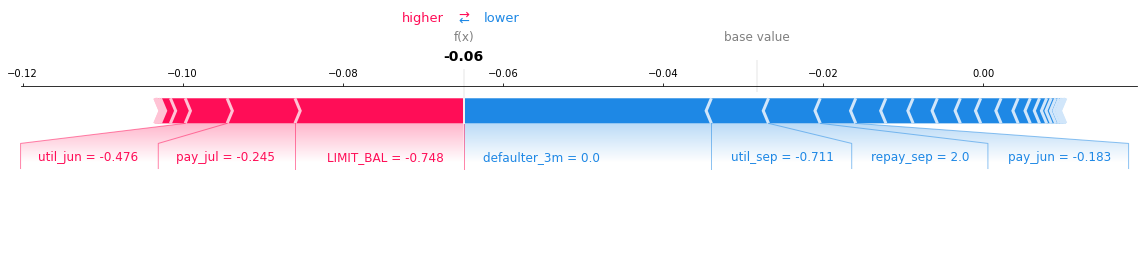

In [68]:
X_test_enc = round(X_test_enc, 3) # for better visualization
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][example_class0_index, :],
    X_test_enc.iloc[example_class0_index, :],
    matplotlib=True,
)

The raw model score is smaller than the base value  so the prediction is class 0, meaning that client will not default.

defaulter_3m =0 (the client has not defaulted in the last 3 months) is most important in pushing the prediction towards lower score.

LIMIT_BAL=-0.748 is most important in pushing the prediction towards higher score.

**Example for class 1 (default)**

In [69]:
# Confirm class of example and assess how confident is the model about the prediction
example_class1_index = 2
pipe_lgbm_tuned.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[example_class1_index]

array([0.46366061, 0.53633939])

In [70]:
pipe_lgbm_tuned.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[example_class1_index]  # raw score of the model for this example

0.1456143149451678

In [71]:
lgbm_explainer.expected_value[1] # base value (on average this is the raw score)

-0.02827843863210337

In [72]:
test_lgbm_shap_values[1][example_class1_index, :].sum() + lgbm_explainer.expected_value[1]

0.14561431494516755

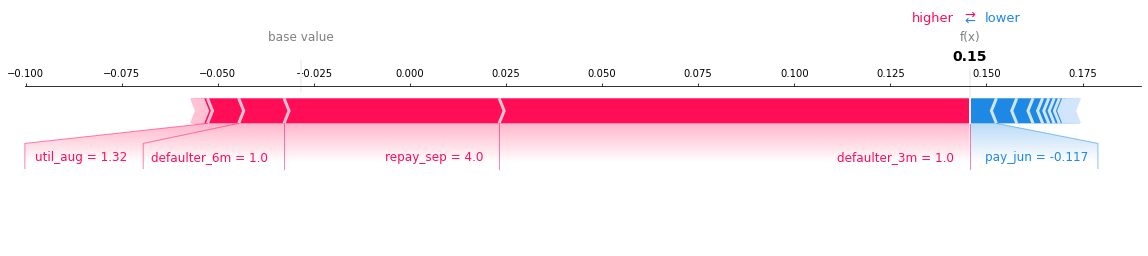

In [73]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][example_class1_index, :],
    X_test_enc.iloc[example_class1_index, :],
    matplotlib=True,
)

The raw model score is bigger than the base value so the prediction is class 1, meaning that the model predicts that the client **will default**.

defaulter_3m =1 (the client has defaulted in the last 3 months) is most important in pushing the prediction towards higher score.

There are not significant features pushing the prediction towards lower score.

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

**Answer_13.1:** 

|Stage   |Summary   |
|----|------|
|Data splitting| 80/20 split, columns renamed|
|EDA| observed class imbalance, no missing data |
|Feature Engineering| 14 new features extracted, 2 of which ranked top in importance|
|Preprocessing| ColumnTransformer created. Only one feature was dropped. Sex feature was discussed, but final decision was to keep it as it will not cause direct harm to a particular group. Following transformations applied- numeric features: StandardScalar, ordinal features: OrdinalEncoder, categorical features: OneHotEncoding, binary features: OneHotEncodig with binary=True|
|Scoring Metric| f1 selected as evaluation metric since we want to minimize false negatives (where negative class is no-default) but also avoid high volume of false positives|
|Baseline| DummyClassifier used highest frequency strategy, so, default recall and f1 score were zero (baseline score)|
|Models Assessment| 6 models were reviewed: LogisticRegression, kNN, SVC, RandomForest, LGBMClassifier and CatBoostClassifier. On f1 scoring, the performance of LGBM was best (~0.52). Random Forest classifier showed Overfitting|
|Feature selection| Attempted RFECV and L1 regularization but not much improvement observed. So, did not use feature selection in further sections|
|Hyperparameter optimization| Obtained only marginal improvement in performance of all the models except Random Forest, which showed an improvement in f1 score 0.09. However, even after improvement, the score was inline with other best performing models|
|Model Selection| Best performing model after hyperparameter optimization is 'Light GBM' with hyperparameters: {num_leaves: 50, n_estimators: 100, learning_rate: 0.001, class_weight: 'balanced'}. RandomForest obtained comparable results but we detected overfitting |
|Feature Importances| default_3m, Limit_bal are the most important features. This is also evident in the EDA |
|Test Scores| Light GBM model (optimized) obtained 0.54 on test data, which was in line with the validation scores|

**Answer_13.2:** During this assignment, we applied multiple techniques for having better predicition of credit card default for a dataset which had class imbalance. Some of these were: feature engineering, feature selection, using different models and scoring metrics, hyperparameter optimization etc. After the evaluation, the best performing model was Light GBM classifier, with tuned hyperparameters. The **achieved "f1" score was ~0.52 on the validation set**. This score was replicated when using the test data, hence, the model performance was reliable.

While experimenting, we observed that the biggest increase in model performance came from feature engineering. We saw a significant improvement in prediction, when we added new domain-specific feature. Based on feature importance analysis, two of these features appeared at the top. As per the models, the strongest predictors for default are (1) default during the past 3 months (2) high credit limit.

**Answer_13.3:** Some ideas that could potentially improve the performance/ interpretability but were not attempted here are:
- ensemble models such as `VotingClassifier`
- further feature engineering (eg. polynomial features)
- under-sampling/over-sampling to deal with class imbalance
- explore different thresholds of `predict_proba`

**Answer_13.4:** In this problem, we wanted to minimise the instances of false negatives, where negative class is no-default. We also, did not want very high instances of false positives. So, we selected "f1" score as the evaluation metric. The f1 score on test data using optimized Ligth GBM model is: **0.54**. This score has been given at the start, as per submission instructions. 

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 

**Answer:** In terms of content, this course covered a lot of interesting technical concepts. However, our two biggest takeaways are:
- Rationale for all the steps (incl. data transformation, feature selection, model building) is extremely critical, as the reliability of results is dependent upon how diligently all these steps were carried out.
- The real world may behave differently from our model and we should not be making tall claims about the real world based on results obtained from the models.

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

from IPython.display import Image

Image("eva-well-done.png")